## Inner products

$$ x^T y = \sum_{i=1}^N x_i y_i $$

#### OpenMP
The vectors `x` and `y` of length `N` are stored in a contiguous array in shared memory.
```c
double sum = 0;
#pragma omp parallel for reduction(+:sum)
for (int i=0; i<N; i++)
    sum += x[i] * y[i];
```

#### MPI
The vectors `x` and `y` are partitioned into $P$ parts of length $n_p$ such that
$$ N = \sum_{p=1}^P n_p . $$
The inner product is computed via
```c
double sum = 0;
for (int i=0; i<n; i++)
    sum += x[i] * y[i];
MPI_Allreduce(MPI_IN_PLACE, &sum, 1, MPI_DOUBLE, MPI_SUM, comm);
```

* Work: $2N$ flops processed rate $R$
* Execution time: $\frac{2N}{RP} + \text{latency}$
* How big is latency?

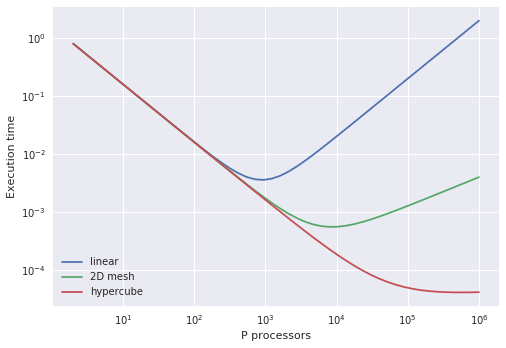

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

P = np.geomspace(2, 1e6)
N = 1e9       # length of vectors
R = 10e9/8    # (10 GB/s per core) (2 flops/16 bytes) = 10/8 GF/s per core
t1 = 2e-6     # 2 µs message latency

def time_compute(P):
    return 2*N / (R*P)

plt.loglog(P, time_compute(P) + t1*(P-1), label='linear')
plt.loglog(P, time_compute(P) + t1*2*(np.sqrt(P)-1), label='2D mesh')
plt.loglog(P, time_compute(P) + t1*np.log2(P), label='hypercube')
plt.xlabel('P processors')
plt.ylabel('Execution time')
plt.legend();

![](FischerBGQAllReduce.png)

### Torus topology

![](https://upload.wikimedia.org/wikipedia/commons/6/60/Torus_from_rectangle.gif)

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1f/3d_torus.png" width="800px" />

* 3D torus: IBM BlueGene/L (2004) and BlueGene/P (2007)
* 5D torus: IBM BlueGene/Q (2011)
* 6D torus: Fujitsu K computer (2011)

### Dragonfly topology
![](CrayAriesDragonfly.png)

### Today's research: reducing contention and interference

![](https://3s81si1s5ygj3mzby34dq6qf-wpengine.netdna-ssl.com/wp-content/uploads/2019/08/cray-slingshot-congestion-control.png)

![](https://3s81si1s5ygj3mzby34dq6qf-wpengine.netdna-ssl.com/wp-content/uploads/2019/08/cray-slingshot-trace-latency.png)

Images from [this article](https://www.nextplatform.com/2019/08/16/how-cray-makes-ethernet-suited-for-hpc-and-ai-with-slingshot/).

#### Compare to BG/Q
* Each job gets an electrically isolated 5D torus
* Excellent performance and reproducibility
* Awkward constraints on job size, lower system utilization.

## Outer product

$$ C_{ij} = x_i y_j $$

* Data in: $2N$
* Data out: $N^2$

## Matrix-vector products

$$ y_i = \sum_{j} A_{ij} x_j $$

How to partition the matrix $A$ across $P$ processors?

### 1D row partition
* Every process needs entire vector $x$: `MPI_Allgather`
* Matrix data does not move
* Execution time
$$ \underbrace{\frac{2N^2}{RP}}_{\text{compute}} + \underbrace{t_1 \log_2 P}_{\text{latency}} + \underbrace{t_b N \frac{P-1}{P}}_{\text{bandwidth}} $$

![Thanks to Abtin Rahimian](05-matvec-row.png)

### 2D partition

* Blocks of size $N/\sqrt{P}$
* "diagonal" ranks hold the input vector
* Broadcast $x$ along columns: `MPI_Bcast`
* Perform local compute
* Sum `y` along rows: `MPI_Reduce` with roots on diagonal
* Execution time
$$ \underbrace{\frac{2N^2}{RP}}_{\text{compute}} + \underbrace{2 t_1 \log_2 P}_{\text{latency}} + \underbrace{\frac{2 t_b N}{\sqrt{P}}}_{\text{bandwidth}} $$

![Thanks to Abtin Rahimian](05-matvec-block.png)

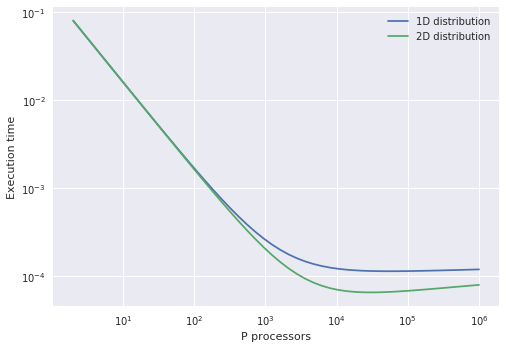

In [38]:
N = 1e4
tb = 8 / 1e9 # 8 bytes / (1 GB/s) ~ bandwidth per core in units of double
tb *= 100

plt.loglog(P, (2*N**2)/(R*P) + t1*np.log2(P) + tb*N*(P-1)/P, label='1D distribution')
plt.loglog(P, (2*N**2)/(R*P) + 2*t1*np.log2(P) + 2*tb*N/np.sqrt(P), label='2D distribution')
plt.xlabel('P processors')
plt.ylabel('Execution time')
plt.legend();